In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from synth_dim_model import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd
import concurrent.futures

import warnings
warnings.filterwarnings("ignore")

In [2]:
def construct_rescaled_hamiltonian_with_PBC_and_theta_term(N, M, V, mu_V_ratio, J_V_ratio, theta):
    
    mu = mu_V_ratio * abs(V)
    J = J_V_ratio * abs(V)
    dim = M**N
    H = np.zeros((dim, dim), dtype=np.complex128)

    # Precompute powers of M for faster state-to-index conversion
    M_powers = np.array([M**i for i in range(N)])

    # Helper function to convert a state index to a state representation (array of states)
    def index_to_state(index):
        return np.array([(index // M_powers[i]) % M for i in range(N-1, -1, -1)])
    
    # Helper function to convert a state representation (array of states) back to an index
    def state_to_index(state):
        return np.dot(state, M_powers[::-1])

    # Apply the chemical potential term
    for alpha in range(dim):
        state = index_to_state(alpha)
        for j in range(N):
            if state[j] == 0:
                H[alpha, alpha] -= mu

    # Apply the tunneling term
    for alpha in range(dim):
        state = index_to_state(alpha)
        for j in range(N):
            for n in range(M):
                if state[j] == n:
                    if n == 0:
                        new_state = state.copy()
                        new_state[j] = M - 1
                        beta = state_to_index(new_state)
                        H[alpha, beta] -= J
                        H[beta, alpha] -= J
                    else:
                        new_state = state.copy()
                        new_state[j] = n - 1
                        beta = state_to_index(new_state)
                        H[alpha, beta] -= J
                        H[beta, alpha] -= J  

    # Apply the interaction term
    for alpha in range(dim):
        state = index_to_state(alpha)
        for i in range(N - 1):
            j = i + 1
            for n in range(M):
                
                if n == 0:                    
                    if state[i] == 0 and state[j] == M - 1:
                        new_state = state.copy()
                        new_state[i], new_state[j] = M - 1, 0
                        beta = state_to_index(new_state)
                        H[alpha, beta] += V
                        H[beta, alpha] += V  
                    
                else:
                    if state[i] == n and state[j] == n - 1:
                        new_state = state.copy()
                        new_state[i], new_state[j] = n - 1, n
                        beta = state_to_index(new_state)
                        H[alpha, beta] += V
                        H[beta, alpha] += V  
                    
    # Rescale H to H_tilde by dividing by |V|
    H_tilde = H / abs(V)
        
    return H_tilde

In [3]:
N = 2
M = 2

V = 1
mu_V_ratio = 3
J_V_ratio = 5

hamiltonian_OBC = construct_rescaled_hamiltonian(N, M, V, mu_V_ratio, J_V_ratio)
hamiltonian_PBC = construct_rescaled_hamiltonian_with_PBC_and_theta_term(N, M, V, mu_V_ratio, J_V_ratio, theta = 0)

In [4]:
print(hamiltonian_OBC)

[[-6.+0.j -5.+0.j -5.+0.j  0.+0.j]
 [-5.+0.j -3.+0.j  1.+0.j -5.+0.j]
 [-5.+0.j  1.+0.j -3.+0.j -5.+0.j]
 [ 0.+0.j -5.+0.j -5.+0.j  0.+0.j]]


In [5]:
print(hamiltonian_PBC)

[[ -6.+0.j -10.+0.j -10.+0.j   0.+0.j]
 [-10.+0.j  -3.+0.j   2.+0.j -10.+0.j]
 [-10.+0.j   2.+0.j  -3.+0.j -10.+0.j]
 [  0.+0.j -10.+0.j -10.+0.j   0.+0.j]]


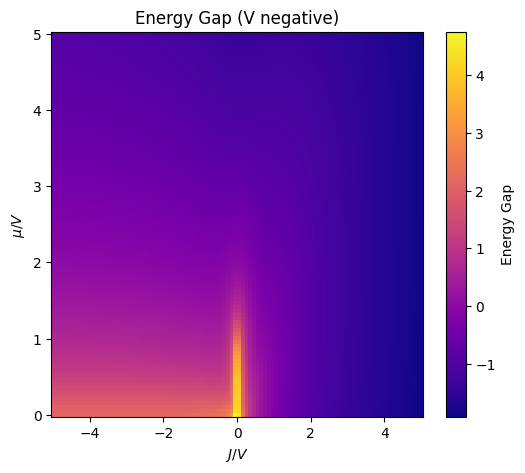

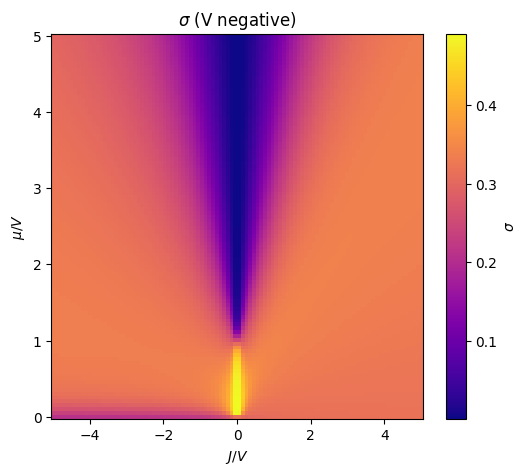

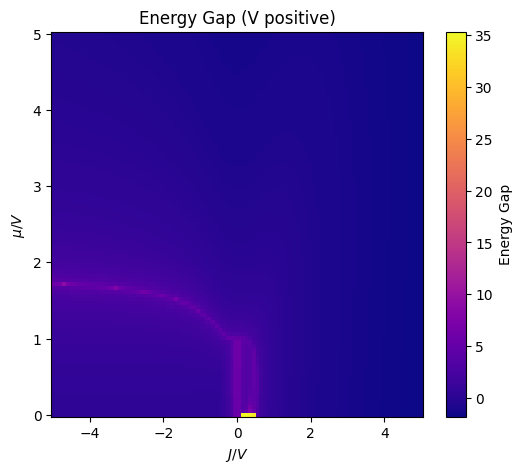

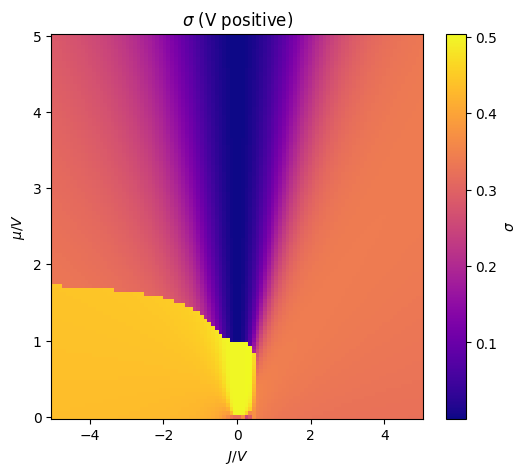

In [6]:
def compute_values(mu_V_ratio, J_V_ratio, V, N, M, states):
    """Compute energy gap and sigma for given parameters."""
    H = construct_rescaled_hamiltonian_with_PBC_and_theta_term(N, M, V, mu_V_ratio, J_V_ratio, theta=0)
    eigenvalues, eigenvectors = exact_diagonalize(H)
    energy_gap = eigenvalues[1] - eigenvalues[0]
    sigma = sigma_ij(0, 1, eigenvectors[0], states, N, M) / M
    return energy_gap, sigma

N = 2
M = 5

min_J_V_ratio = -5
max_J_V_ratio = 5
max_mu_V_ratio = 5
resolution = 100

mu_V_ratios = np.linspace(0, max_mu_V_ratio, resolution)
J_V_ratios = np.linspace(min_J_V_ratio, max_J_V_ratio, resolution)
mu_V_ratio_grid, J_V_ratio_grid = np.meshgrid(mu_V_ratios, J_V_ratios)

for V in [-1, 1]:
    sigma_grid = np.zeros_like(mu_V_ratio_grid)
    energy_gap_over_V_grid = np.zeros_like(mu_V_ratio_grid)
    states, _ = enumerate_states(N, M)
    
    # Use ThreadPoolExecutor for parallel processing
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future_to_index = {}
        
        for i, mu_V_ratio in enumerate(mu_V_ratios):
            for j, J_V_ratio in enumerate(J_V_ratios):
                future = executor.submit(compute_values, mu_V_ratio, J_V_ratio, V, N, M, states)
                future_to_index[future] = (j, i)
        
        for future in concurrent.futures.as_completed(future_to_index):
            j, i = future_to_index[future]
            try:
                energy_gap, sigma = future.result()
                energy_gap_over_V_grid[j, i] = energy_gap
                sigma_grid[j, i] = sigma
            except Exception as e:
                print(f"Error computing values for indices ({j}, {i}): {e}")
    
    sign = "positive" if V > 0 else "negative"

    # Plot energy gap
    plt.figure(figsize=(6, 5))
    plt.pcolormesh(J_V_ratio_grid, mu_V_ratio_grid, np.log(1/energy_gap_over_V_grid), shading='auto', cmap='plasma')
    plt.colorbar(label="Energy Gap")
    plt.xlabel(r"$J/V$")
    plt.ylabel(r"$\mu/V$")
    plt.title(f"Energy Gap (V {sign})")
    plt.show()

    # Plot sigma
    plt.figure(figsize=(6, 5))
    plt.pcolormesh(J_V_ratio_grid, mu_V_ratio_grid, sigma_grid, shading='auto', cmap='plasma')
    plt.colorbar(label=r"$\sigma$")
    plt.xlabel(r"$J/V$")
    plt.ylabel(r"$\mu/V$")
    plt.title(f"$\sigma$ (V {sign})")
    plt.show()
